# Socioeconomic characteristics of at-risk populations impacted by the aging dam infrastructure in the USA - Who is facing the risk of potential dam failures? 

**Authors**: Jinwoo Park <sup>1,2</sup>, Shaowen Wang<sup>1,2,*</sup>, Courtney Flint <sup>3</sup>, Upmanu Lall <sup>4</sup><br>
<sup>1</sup> Department of Geography and Geographic Information Science, University of Illinois Urbana-Champaign <br>
<sup>2</sup> CyberGIS Center for Advanced Digital and Spatial Studies, University of Illinois Urbana-Champaign <br>
<sup>3</sup> Department of Environment & Society,Utah State University <br>
<sup>4</sup> Department of Earth & Environmental Engineering, Columbia University <br>
<sup>*</sup> Correspondence: Shaowen Wang, shaowen@illinois.edu <br>

Last Updated Date: June 15, 2023

### Abstract:
The dam infrastructure in the conterminous United States (CONUS) has exceeded its designed service lives to a large extent, posing an increased risk of failures that can cause catastrophic disasters with substantial economic and human losses. However, limited attention has been paid to the characteristics of at-risk populations, hindering adequate understanding and preparedness for emergency planning. Our study proposes a framework employing spatial metrics to discover where and whether socially vulnerable populations are more exposed to flood inundation risks induced by dam failures. By applying the framework to 345 dams in the CONUS, we found that characteristics of at-risk populations vary extensively across space. To better understand this spatial variability, we categorized the dams into five clusters based on at-risk population characteristics. Our findings reveal that dams in California and New England face particularly high consequential risks as their failure could impact socially vulnerable populations.

### Notebook Outline 
***Hyperlinks work only within the Jupuyter environment***

* [On-the-fly analysis with CyberGIS-Compute](#CyberGIS-Compute)
* [Overall characteristics of at-risk populations in the CONUS](#Overall)
* [Clusters of dams per characteristics of the at-risk population](#Clusters)
* [Spatial patterns of dam clusters](#Spatial)

Import necessary packages

In [1]:
import geopandas as gpd
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.patheffects as pe
import math
from sklearn.decomposition import PCA
import scipy
import statsmodels.api as sm
import os

<hr id="CyberGIS-Compute" />

## 0. On-the-fly analysis with CyberGIS-Compute

The following cell will allow users to run the proposed framework, which reveals the characteristics of the at-risk population to potential failures of aging dam infrastructure. Due to the computational intensity, CyberGIS-Compute will only allow running for one dam, while the actual analysis was conducted with a parallel computing approach. <br>

**Note**: Detailed information of the proposed framework is available at <a href="./Local_Analysis_Multi_Scenario.ipynb">a different notebook</a>.

In [2]:
!pip install cybergis-compute-client

In [3]:
from cybergis_compute_client import CyberGISCompute

<h4 style="color:red;"> User Interaction Required </h4>

- Run the two cells below 
- Click on "Submit Job" on the "Your Job Status" tabpage 
- Wait until Job is finished (20-25 mins)
- Proceed to the next cell

**Provide dam id on the National Inventory of Dams (NID) to the `dam_id` text box.** Then, click `Submit New Job`. 

In [4]:
cybergis = CyberGISCompute(url="cgjobsup.cigi.illinois.edu", isJupyter=True, protocol="HTTPS", port=443, suffix="v2")
cybergis.show_ui(defaultJob='population_vulnerable_to_dam_failure')

📃 Found "cybergis_compute_user.json! NOTE: if you want to login as another user, please remove this file
🎯 Logged in as jparkgeo@illinois.edu@jupyter.iguide.illinois.edu


When you see `JOB_ENDED` on `Your Job Status` tab, you can download your results on `Download Job Results` tab. <br>
Once the files are downloaded, you can go to your home directory of Jupyter environment. You will see a folder name starting with `globus_download_`. Please enter the folder and find `Multi_F_Results` and `N_0` folders. The folder should have the following three files. 
* `Multi_F_fim.geojson`: GEOID of inundated and non-inundated regions
* `Multi_F_lm.geojson`: Bivariate LISA result
* `Multi_F_mi.geojson`: Bivariate Moran's I result

Load (pre)computed sample results...

In [5]:
if cybergis.recentDownloadPath:
    result_path = cybergis.recentDownloadPath
else:
    result_path = './sample_results'
print(f"Loading results from {result_path}")

Loading results from ./sample_results


In [6]:
sample_mi = gpd.read_file(os.path.join(result_path, 'Multi_F_Results', 'N_0', 'Multi_F_mi.geojson'))
sample_lm = gpd.read_file(os.path.join(result_path, 'Multi_F_Results', 'N_0', 'Multi_F_lm.geojson'))
sample_fim = gpd.read_file(os.path.join(result_path, 'Multi_F_Results', 'N_0', 'Multi_F_fim.geojson'))

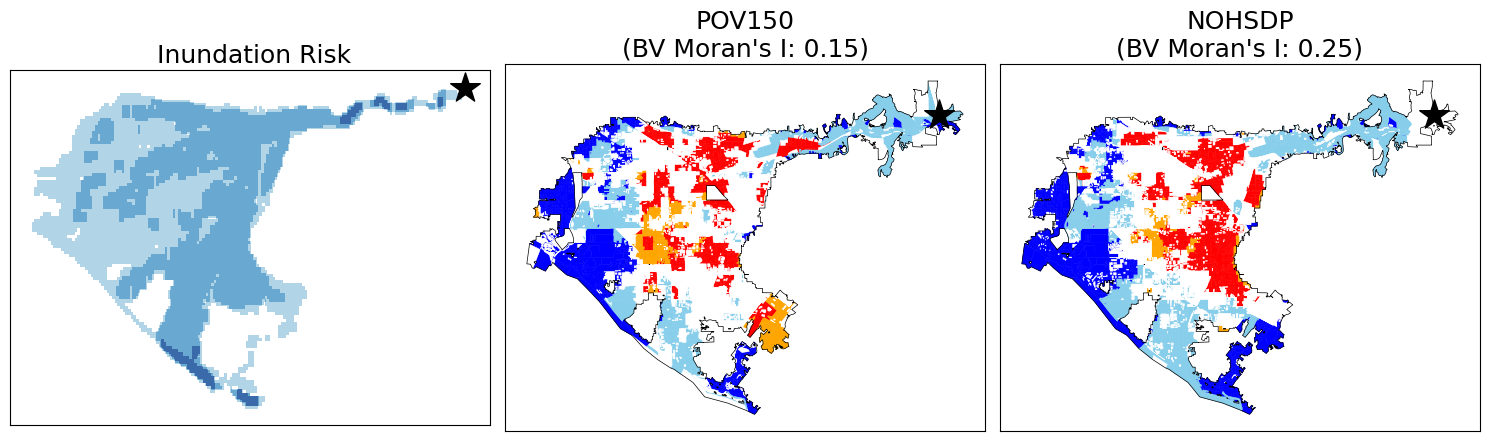

In [7]:
dam_id = 'CA10022'

fig, axes = plt.subplots(1, 3, figsize=(15, 10))

lisa_color = {'HH': 'red', 'LL': 'blue', 'HL': 'skyblue', 'LH': 'orange', 'Not_Sig': 'white'}
boundary_gdf = gpd.GeoDataFrame([0], geometry=[sample_lm.unary_union])

color_brewer = ['#9ecae1','#4292c6','#084594']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=3)

# Plot Inundation Risk from various dam failure scenarios
sample_fim.plot('value', ax=axes[0], cmap=cm, alpha=0.8)
sample_mi.plot(marker="*", color='black', markersize=500, ax=axes[0])

axes[0].set_title('\n Inundation Risk', fontsize=18)
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)

# Plot Bivariate LISA
'''
# The title of each cell provides Bivariate Moran's I 
# Census block color codes:
## Red: HH cluster (high inundation risk and high social vulnerability)
## Skyblue: HL cluster (high inundation risk and low social vulnerability)
## Orange: LH cluster (low inundation risk and high social vulnerability)
## Blue: LL cluster (low inundation risk and low social vulnerability)
'''

plot_cols = ['POV150', 'NOHSDP']
for idx, val in enumerate(plot_cols, start=1):
    for key in lisa_color.keys():
        sample_lm.loc[(sample_lm[f'LISA_{val}'] == key)].plot(ax=axes[idx], color=lisa_color[key], edgecolor='face', lw=0.3, legend=True)

    boundary_gdf.boundary.plot(ax=axes[idx], lw=0.5, color='black')
    sample_mi.plot(marker="*", color='black', markersize=500, ax=axes[idx])
    axes[idx].set_title(label=f"{val}\n(BV Moran's I: {round(sample_mi[f'MI_{val}'].values[0], 2)})",
                        fontsize=18)
    
    axes[idx].get_xaxis().set_visible(False)
    axes[idx].get_yaxis().set_visible(False)

    
plt.tight_layout()
plt.show()

## Results of the pre-computed analysis 

Given the computational intensity of our work, this notebook will use the pre-computed results have been run on High-Performance Computing Resources (HPC). <br>
The following cell will import results file (`mi`) that has Bivaraite Moran's I. In addition, we load `states` and `basins` file for plotting purposes. 

In [8]:
mi = gpd.read_file('./results/Multi_F_mi_all.geojson')
mi_cols = [col for col in mi.columns.to_list() if col.startswith('MI')]
mi = mi.fillna(0)

state_lookup = pd.read_csv('./census_geometry/state_lookup.csv')

states = gpd.read_file('./census_geometry/tl_2022_us_state.geojson')
states = states.merge(state_lookup, left_on='STUSPS', right_on='Abbr')
states = states.loc[states['ContiguousUS'] == 1]
states = states.to_crs(epsg=4326)

basins = gpd.read_file('./census_geometry/WBD_HU2.geojson')
basins = basins[['states', 'huc2', 'name', 'geometry']]
basins = basins.to_crs(epsg=4326)
basins = gpd.clip(basins, states)

In [9]:
# Assign HUC2 basin to each dam
for idx, row in basins.iterrows():
    mi.loc[mi['geometry'].within(row['geometry']), 'HUC2'] = row['huc2']

<hr id="Overall" />

## 1. Overall characteristics of at-risk populations in the CONUS

The following cell conducts a two-tailed t-test (n: 345, degree of freedom: 344) and Bonferroni Correction, where the p-value is less than 0.00015 (i.e., 0.05 / 345 (the number of dams)).

In [10]:
mi_df = mi[[col for col in mi.columns if col.startswith('MI')]]

for col in mi_df.columns:
    mi_df = mi_df.loc[pd.notna(mi_df[col])]

ttest_df = pd.DataFrame(data={'var': mi_df.columns.to_list()}, 
                        columns=['var', 'mean', 'std','coef', 'pval'])

# Conduct T-test
for col in mi_cols:
    ttest_ = scipy.stats.ttest_1samp(mi_df[col], popmean=0)
    ttest_df.loc[ttest_df['var'] == col, 'mean'] = mi_df[col].mean()
    ttest_df.loc[ttest_df['var'] == col, 'std'] = mi_df[col].std()
    ttest_df.loc[ttest_df['var'] == col, 'coef'] = ttest_[0]
    ttest_df.loc[ttest_df['var'] == col, 'pval'] = ttest_[1]

# Conduct Bonferroni Correction
ttest_df['bonf'] = sm.stats.multipletests(ttest_df['pval'], 0.05, method='bonferroni')[0] 
ttest_df

,var,mean,std,coef,pval,bonf
0,MI_POV150,-0.038646,0.12285,-5.843031,0.0,True
1,MI_UNEMP,-0.021929,0.105895,-3.846407,0.000143,True
2,MI_HBURD,-0.051007,0.12759,-7.425488,0.0,True
3,MI_NOHSDP,-0.029363,0.120683,-4.519273,0.000009,True
4,MI_UNINSUR,-0.004378,0.125387,-0.648566,0.517051,False
5,MI_AGE65,0.055221,0.114577,8.951958,0.0,True
6,MI_AGE17,-0.017572,0.112118,-2.911012,0.003837,False
7,MI_DISABL,-0.005086,0.117367,-0.804822,0.421478,False
8,MI_SNGPNT,-0.040697,0.100271,-7.538696,0.0,True
9,MI_LIMENG,-0.036877,0.116173,-5.896069,0.0,True


Our analysis indicated that the potential failure of dams in the CONUS would affect the less socially vulnerable for most variables. Out of 16 census data units, nine variables (i.e., POV150, UNEMP, HBURD, NOHSDP, SNGPNT, LIMENG, MINRTY, MUNIT, and NOVEH) provided their means lower than 0 (i.e., negative spatial correlation) and were statistically significant. 

**Note**: 
* Histograms illustrate the distribution of Bivariate Moran’s I (i.e., spatial relationship between the risk of flood inundation and the social vulnerability for each census variable). <br>
* Solid and dashed redlines represent the mean (μ) and ± one standard deviation (σ) for each distribution, respectively. 
* Black line represents the normal distribution with a mean of 0 and the same standard deviation as the data. 
* Title of each cell specifies whether the Bivariate Moran’s I distribution is statistically different from the normal distribution that has the same deviation (black curve line).


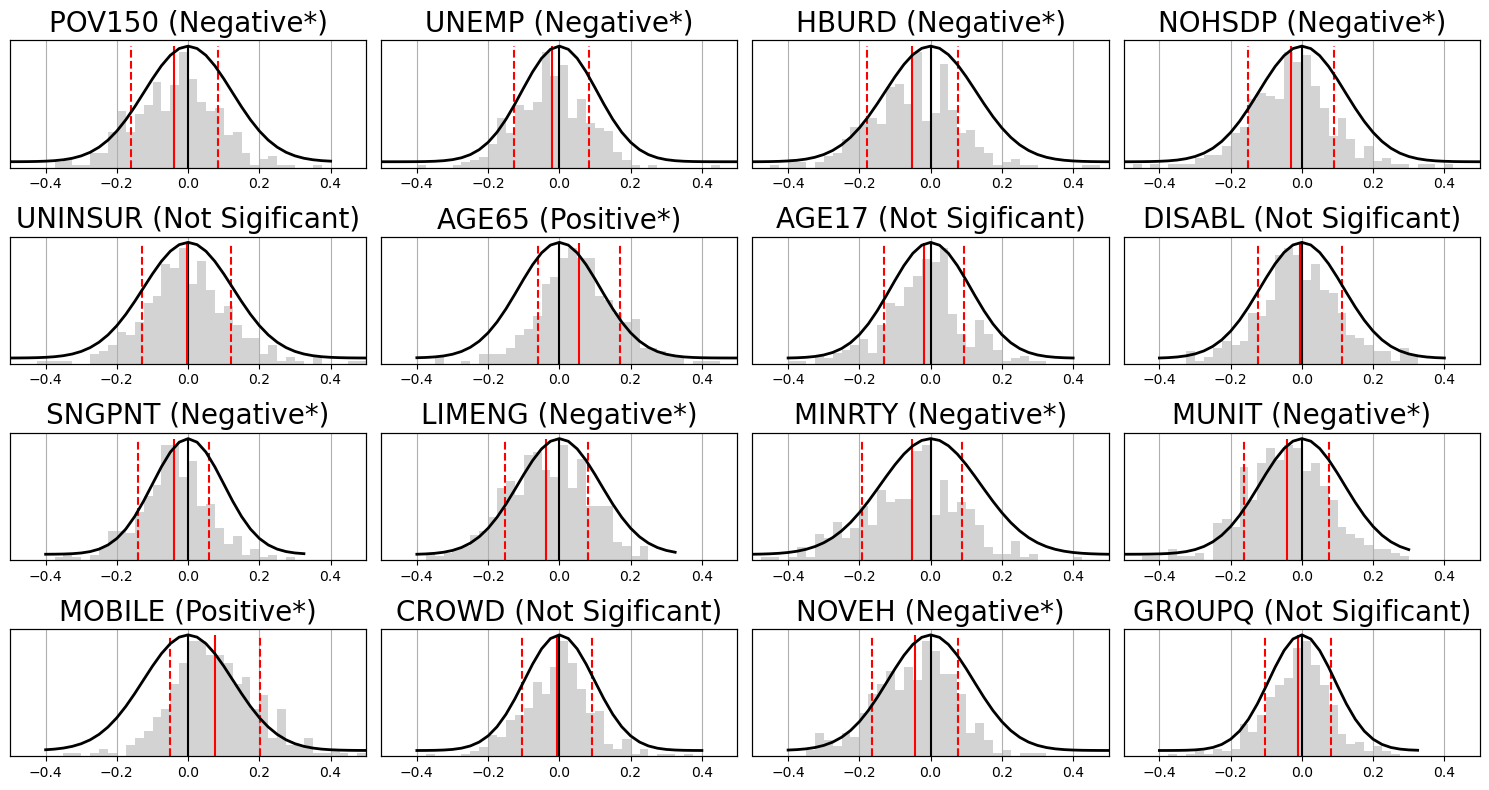

In [11]:
fig, axes = plt.subplots(4, 4, figsize=(15,8))
ax = axes.reshape(-1)

binwidth = 0.025
n = 10
pvalue_list = [] # For Bonferroni Correction

for idx, row in ttest_df.iterrows():
    
    bins = np.arange(math.floor(min(mi_df[row['var']]) * n) / n, math.ceil(max(mi_df[row['var']]) * n) / n + binwidth, binwidth)
    
    mi_df[row['var']].hist(ax=ax[idx], bins=bins, color='lightgrey')
    
    # Generate Normal Distribution with the mean of 0 and the same std. 
    ax2 = ax[idx].twinx()
    mu, sigma = 0, mi_df[row['var']].std()
    s = np.random.default_rng().normal(loc=0.0, scale=sigma, size=10000)
    ax2.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
                 np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
                 linewidth=2, color='black')

    ylim = ax[idx].get_ylim()[1]
    ax[idx].vlines(0, 0, ylim, color='black')
    ax[idx].vlines(mi_df[row['var']].mean(), 0, ylim, color='red')
    ax[idx].vlines(mi_df[row['var']].mean() + mi_df[row['var']].std(), 0, ylim, color='red', linestyles='dashed')
    ax[idx].vlines(mi_df[row['var']].mean() - mi_df[row['var']].std(), 0, ylim, color='red', linestyles='dashed')

    if row['bonf'] == True:
        if row['mean'] > 0:
            label = 'Positive*'
        else:
            label = 'Negative*'
    else:
        label = 'Not Sigificant'
    
    ax[idx].set_title(label=f"{row['var'].split('_')[1]} ({label})", fontsize=20)
    ax[idx].set_xlim(-0.5, 0.5)
    ax[idx].get_yaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
plt.tight_layout()
plt.show()

<hr id="Clusters" />

## 2. Clusters of dams per characteristics of the at-risk population

Our further analysis clusters dams by examining how many census variables exhibited positive or negative spatial correlation coefficients. This section proceeds with the following two steps: Principal Component Analysis (PCA) and K-Means clustering. 

### 2.1. PCA for 16 Moran's I (Risk of inundation & SVI-related Census data)

Principal Component Analysis (PCA) was employed to decrease the dimension of 16 Bivariate Moran's I to five principal components (PCs), explaining 73% of the original variance. 

In [12]:
pca_n = 5
pca = PCA(n_components=pca_n, svd_solver='full', random_state=17)
pca_result = pca.fit_transform(mi_df)
print(f'Explained variation per principal component: {pca.explained_variance_ratio_}')
print(f'Cumulative variance explained by {pca_n} principal components: {round(np.sum(pca.explained_variance_ratio_), 2)}')


Explained variation per principal component: [0.36056    0.13039026 0.1133018  0.07158997 0.05103134]
Cumulative variance explained by 5 principal components: 0.73


In [13]:
# Results from pca.components_
dataset_pca = pd.DataFrame(abs(pca.components_), columns=mi_df.columns, index=[f'PC_{v}' for v in range(1, pca_n+1)])
pca_df = pd.DataFrame(pca_result, columns=[f"Component_{v+1}" for v in range(0, pca_n)])
mi_df= pd.concat([mi_df, pca_df], axis=1)

print("\n*************** Most important features *************************")
for v in range(1, pca_n+1):
    print(f'As per PC \n', (dataset_pca[dataset_pca > 0.3].iloc[v-1]).sort_values(ascending=False).dropna())   
print("\n******************************************************************")

mi_df


*************** Most important features *************************
As per PC 
 MI_MINRTY    0.408300
MI_HBURD     0.348248
MI_POV150    0.348180
MI_NOVEH     0.315388
Name: PC_1, dtype: float64
As per PC 
 MI_MOBILE    0.539182
MI_NOHSDP    0.431296
MI_MUNIT     0.367176
MI_DISABL    0.347966
Name: PC_2, dtype: float64
As per PC 
 MI_DISABL    0.477725
MI_AGE17     0.455986
MI_AGE65     0.375217
Name: PC_3, dtype: float64
As per PC 
 MI_UNINSUR    0.523699
MI_AGE17      0.472997
MI_SNGPNT     0.309120
Name: PC_4, dtype: float64
As per PC 
 MI_LIMENG    0.452021
MI_HBURD     0.405160
MI_MOBILE    0.305848
Name: PC_5, dtype: float64

******************************************************************


,MI_POV150,MI_UNEMP,MI_HBURD,MI_NOHSDP,MI_UNINSUR,MI_AGE65,MI_AGE17,MI_DISABL,MI_SNGPNT,MI_LIMENG,...,MI_MUNIT,MI_MOBILE,MI_CROWD,MI_NOVEH,MI_GROUPQ,Component_1,Component_2,Component_3,Component_4,Component_5
0,0.017772,-0.099167,0.111582,-0.109785,-0.178308,-0.013277,0.004232,0.020947,0.013254,-0.167206,...,0.074528,-0.068617,0.020064,0.073653,-0.007337,0.105711,-0.254843,0.087858,-0.136340,0.107148
1,0.155147,0.163325,0.229622,-0.055764,-0.157273,0.096890,-0.125683,-0.132328,0.014848,0.129096,...,0.106022,0.071188,-0.028229,0.027247,0.202736,0.292271,-0.175378,0.192527,-0.003494,-0.015381
2,-0.181884,-0.151604,-0.194586,-0.201652,-0.083327,0.146950,0.046804,-0.247930,-0.187883,-0.196340,...,-0.245603,0.244990,-0.043612,-0.298288,0.160329,-0.531505,0.006871,-0.133462,0.065045,0.054826
3,0.259143,0.135680,0.292829,0.192453,0.103470,-0.206889,0.251088,0.025816,0.237717,0.180437,...,0.171349,-0.249586,0.177079,0.138698,-0.103665,0.914345,-0.104837,-0.207608,-0.225626,0.024040
4,0.096451,-0.012027,-0.048638,0.235570,0.190141,-0.254621,0.119883,-0.089960,-0.122915,0.130200,...,-0.151156,0.010738,0.294876,-0.025660,0.233038,0.454985,0.187409,-0.329751,0.063275,-0.122092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,0.089522,0.041687,0.071678,-0.002201,-0.109035,0.098076,-0.110797,0.049854,0.008170,0.085857,...,-0.000515,-0.041789,0.044651,0.044993,0.116987,0.193102,-0.079776,0.170759,-0.058668,-0.079899
341,-0.064093,-0.040730,-0.083366,-0.042582,0.104623,0.081523,0.108361,-0.090647,0.075966,0.020753,...,-0.038944,0.045011,0.001149,-0.060279,-0.075143,0.066602,-0.003415,-0.169679,0.006108,0.021440
342,-0.205656,-0.104556,-0.241421,-0.248494,-0.151331,0.413720,-0.068682,0.246862,-0.226244,-0.309357,...,-0.244820,0.359618,-0.045632,-0.196567,-0.165583,-0.699479,0.236985,0.259545,0.015776,0.066070
343,0.027125,0.069448,0.025589,-0.166302,0.022552,-0.111240,0.048369,-0.259167,0.060161,-0.022016,...,-0.023413,-0.053687,-0.103615,0.025335,-0.025329,0.167125,-0.248744,-0.143681,-0.066144,0.112934


### 2.2. K-Means Clustering using PCA results

K-means clustering took the six PCs and clustered them into five groups. Given that the clustering quality is subject to the number of clusters, we employed the Silhouette method; it identifies the optimal number that maximizes inter-cluster variation and minimizes intra-cluster variation. The five clusters provided the second-highest silhouette coefficient (0.1844), while the highest coefficient (0.2768) was obtained for the two clusters.

2
{2: 0.2849, 3: 0.1985, 4: 0.1954, 5: 0.2085, 6: 0.1902, 7: 0.1988, 8: 0.176, 9: 0.1581, 10: 0.1696}


<BarContainer object of 9 artists>

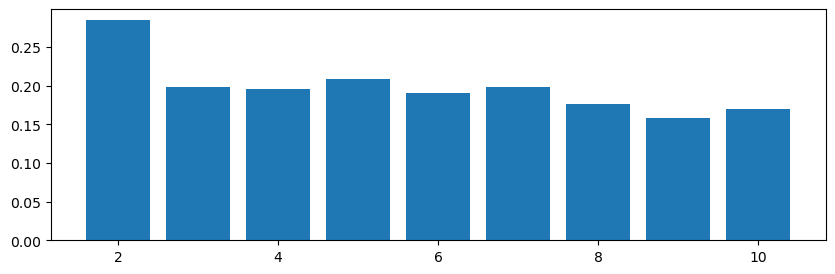

In [14]:
def determine_number_of_cluster(array):
    km_cost = []  # Sum of squared distances of samples to their closest cluster center.
    distortions = []  # the average of the squared distances from the cluster centers of the respective clusters.Typically, the Euclidean distance metric is used.
    km_silhouette = {}

    for i in range(2, 11):
        KM = KMeans(n_clusters=i, max_iter=999, n_init = 99, random_state=17)
        KM.fit(array)

        # Calculate Silhouette Scores
        preds = KM.predict(array)
        silhouette = silhouette_score(array, preds)
        km_silhouette[i] = silhouette

    print(max(km_silhouette, key=km_silhouette.get))
        
    return km_silhouette


def kmeans_cluster(array, num_of_cluster):
    kmeans = KMeans(n_clusters=num_of_cluster, max_iter=999, n_init = 99, random_state=17)
    kmeans.fit(array)
    y_kmeans = kmeans.predict(array)
    
    cluster_df = pd.DataFrame({'cluster': y_kmeans}, index=array.index)
    cluster_df['cluster'] = cluster_df['cluster'].astype(str)
    
    return cluster_df


# silhouette_scores = determine_number_of_cluster(mi_[plot_cols_mi])
silhouette_scores = determine_number_of_cluster(mi_df[[f"Component_{v+1}" for v in range(0, pca_n)]])
print({idx: round(val, 4) for idx, val in silhouette_scores.items()})

# We select the second highest silhouette coefficient as the highest silhouette coefficient indicates only 2 groups. 
mi_copy = kmeans_cluster(mi_df[[f"Component_{v+1}" for v in range(0, pca_n)]], 5)
mi['cluster'] = mi_copy['cluster']
mi.replace({'cluster': {'1': 'A', '2': 'B', '0': 'C', '4': 'D', '3': 'E'}}, inplace=True)

fig, ax = plt.subplots(figsize=(10,3))
ax.bar(silhouette_scores.keys(), silhouette_scores.values())

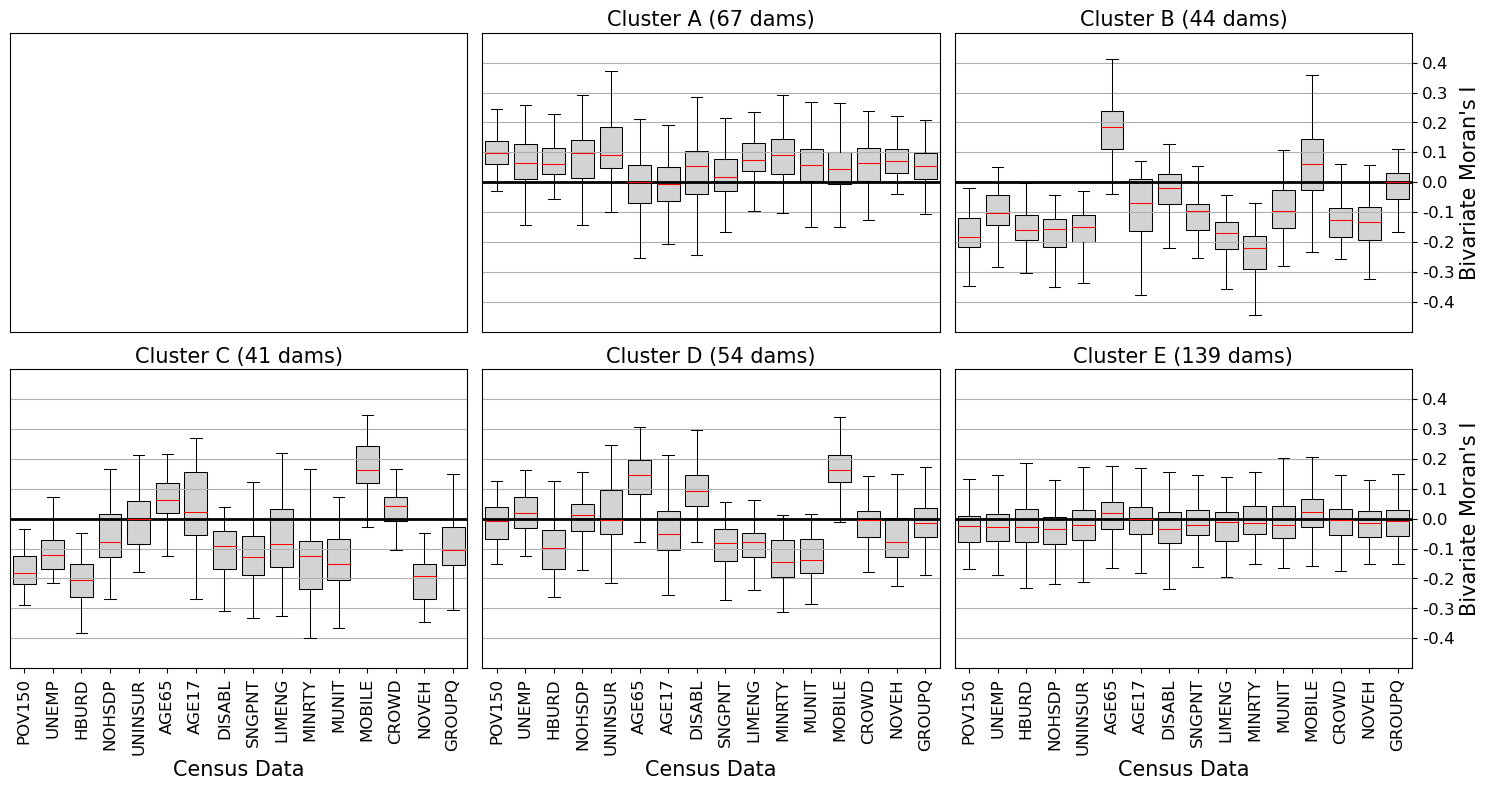

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.reshape(-1)

# Class A: High vulnerability population - Red
# Class B: Low vulnerability population - Blue
# Class C: Partially low vulnerability (Poverty, Unemployment, Houseburden, Single Parent, 
#          Enlgihsh, Minority, MultiUnit, NoVehicle) - Lightblue
# Class D: Mixture of vulnerability (High Elderly pop, Disability, Mobile home and 
#                                    Low Houseburden, Minority, Limited English) - Lightgreen
# Class E: No Major Pattern - Grey

PROPS = {'boxprops':{'facecolor':'#d3d3d3', 'edgecolor':'black'},
         'medianprops':{'color':'red'},
         'whiskerprops':{'color':'black'},
         'capprops':{'color':'black'}
        }

for idx, c in enumerate(['A', 'B', 'C', 'D', 'E'], start=1):

    temp_cluster = mi.loc[mi['cluster'] == c, 
                          [col for col in mi.columns if col.startswith('MI')]
                         ].melt()
    sns.boxplot(x = 'variable', y = 'value', data=temp_cluster, ax=axes[idx], showfliers=False, linewidth=0.75, **PROPS)

    axes[idx].set_ylim(-0.5, 0.5)
    axes[idx].set_yticks([v / 10 for v in range(-4, 5, 1)])
    axes[idx].set_yticklabels([f"{v / 10}" for v in range(-4, 5, 1)], fontsize=12)
    axes[idx].text(0.5, 1.01, f'Cluster {c} ({round(temp_cluster.shape[0]/16)} dams)', 
                 ha = 'center', va = 'bottom', fontsize=15, transform=axes[idx].transAxes)
    axes[idx].axhline(0, color='black', linewidth=2)
    axes[idx].yaxis.grid(True)
#     axes[c].xaxis.grid(True)
    
    if (c == 'B') | (c == 'E'):
        axes[idx].set_ylabel("Bivariate Moran's I", fontsize=15)
        axes[idx].yaxis.set_label_position("right")
        axes[idx].yaxis.tick_right()
    else:
        axes[idx].yaxis.set_tick_params(labelleft=False, left=False)
        axes[idx].set_ylabel('')
    
    if (c == 'C') | (c == 'D') | (c == 'E'):
        axes[idx].set_xlabel("Census Data", fontsize=15)
        axes[idx].set_xticklabels([col.split('_')[1] for col in mi.columns if col.startswith('MI')], 
                                  rotation = 'vertical', fontsize=12)
    else:
        axes[idx].set_xlabel('')
        axes[idx].get_xaxis().set_visible(False)

axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

<hr id="Spatial" />

## 3. Spatial patterns of dam clusters

Out of 345 dams, each cluster has the percentage as follows: Cluster A (19%), Cluster B (13 %), Cluster C (12 %), Cluster D (16 %), and Cluster E (40 %). In addition, we calculated the percentage of dams per cluster and hydrological unit region (HUC2). <br>
Among 18 regions in the CONUS, 11 regions have more than five dams. Ohio River basin has the largest number (74 dams), followed by the Arkansas-White-Red region (50 dams). Out of 345 dams, Tennessee and Upper Colorado regions have 0 dams, and the following regions have five or fewer dams: Souris-Red-Rainy (5), Rio Grande (4), Lower Colorado (3), Great Lakes (2), and Great Basin (1). We excluded these regions for further analysis to avoid potential biased interpretation caused by insufficient dam counts.

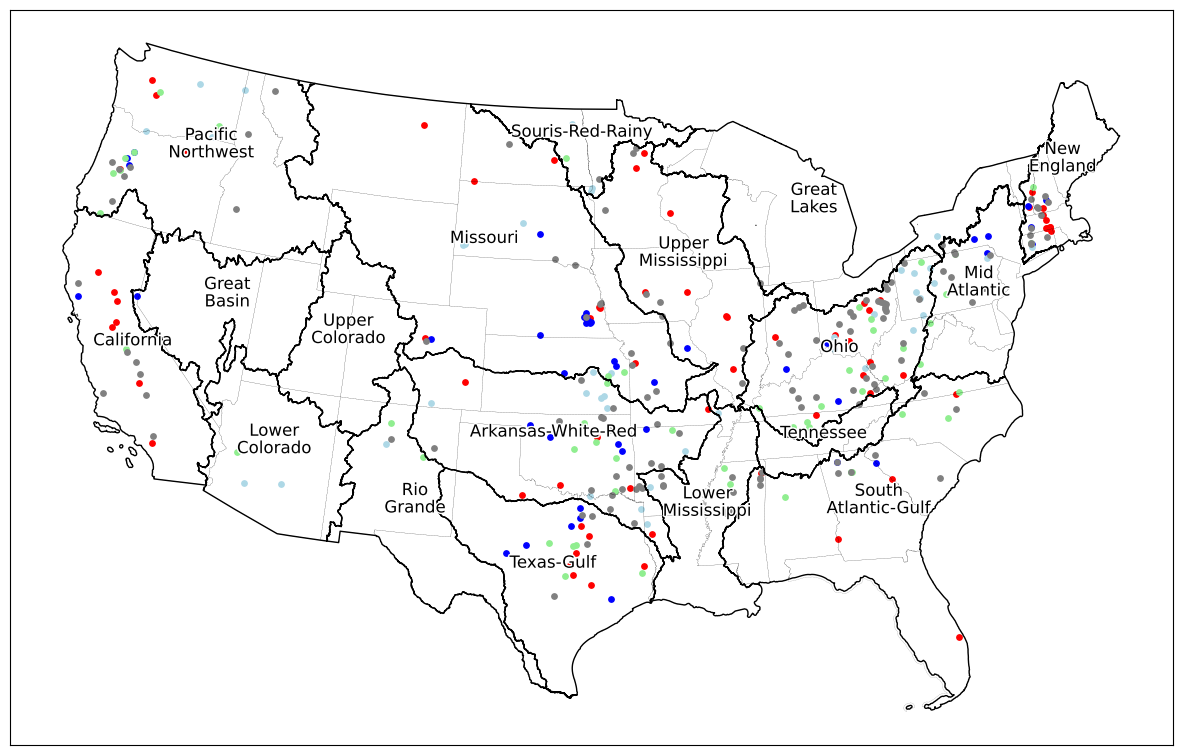

In [16]:
# Class A: High vulnerability population - Red
# Class B: Low vulnerability population - Blue
# Class C: Partially low vulnerability (Poverty, Unemployment, Houseburden, Single Parent, 
#          Enlgihsh, Minority, MultiUnit, NoVehicle) - Lightblue
# Class D: Mixture of vulnerability (High Elderly pop, Disability, Mobile home and 
#                                    Low Houseburden, Minority, Limited English) - Lightgreen
# Class E: No Major Pattern - Grey

mi_plot = mi.copy(deep=True)
mi_plot = mi_plot.to_crs(epsg=5070)
mi_plot['cluster'] = mi_plot['cluster'].astype(str)

basins = basins.to_crs(epsg=5070)
states = states.to_crs(epsg=5070)


fig, ax = plt.subplots(figsize=(15,15))
basins.boundary.plot(ax=ax, color='black', linewidth=1)
states.boundary.plot(ax=ax, color='black', linewidth=0.1, linestyle='dashed')
basins.apply(lambda x: ax.annotate(text='\n'.join(x['name'].split(' ')[:-1]), 
                                   size=12, 
                                   xy=x.geometry.centroid.coords[0], 
                                   ha='center',
                                   path_effects=[pe.withStroke(linewidth=2, foreground="white")]
                                  ),
             axis=1)

mi_plot.loc[mi_plot['cluster'] == 'A'].plot(ax=ax, color='red', markersize=15)  # Class A: High vulnerability population - Red
mi_plot.loc[mi_plot['cluster'] == 'B'].plot(ax=ax, color='blue', markersize=15) # Class B: Low vulnerability population - Blue
mi_plot.loc[mi_plot['cluster'] == 'C'].plot(ax=ax, color='lightblue', markersize=15)   # Class C: Partially low vulnerability - Lightblue
mi_plot.loc[mi_plot['cluster'] == 'D'].plot(ax=ax, color='lightgreen', markersize=15)   # Class D: Mixture of vulnerability - Lightgreen
mi_plot.loc[mi_plot['cluster'] == 'E'].plot(ax=ax, color='grey', markersize=15)   # Class E: No Major Pattern - Grey

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

Several hydrological unit regions provide a notable percentage for specific dam clusters. A significant portion of dams in Upper Mississippi (50%), California (44%), New England (36%), and Texas-Gulf (32%) regions were classified as Cluster A. <br>
A substantial percentage of Cluster B dams (i.e., dams potentially affecting the less socially vulnerable) was observed in Missouri (36%) and Texas-Gulf (27%) regions. <br>
Ohio and Arkansas-White-Red regions are the regions that have the largest and the second largest number of dams, but they provided a similar proportion of dams to the ones from 345 dams. In other words, most dams in these regions were classified as Cluster E. 

In [ ]:
huc2_regions = ['Pacific Northwest Region', 'Missouri Region', 'Upper Mississippi Region', 
                'Ohio Region', 'Mid Atlantic Region', 'California Region', 
                'Arkansas-White-Red Region', 'Texas-Gulf Region', 'Lower Mississippi Region', 
                'South Atlantic-Gulf Region', 'New England Region']

fig, axes = plt.subplots(2, 6, figsize=(15, 5))
axes = axes.reshape(-1)

for idx, huc2_region in enumerate(huc2_regions, start=1):
    huc2 = basins.loc[basins['name'] == huc2_region, 'huc2'].values[0]
    huc2_mi = mi.loc[mi['HUC2'] == huc2]
    print(f"Basin Name: {huc2_region}, Associated Dam Counts: {huc2_mi.shape[0]}")
    
    if huc2_mi.shape[0] > 5:
        cluster_count = huc2_mi.groupby('cluster').count()
        
        for cluster in ['A', 'B', 'C', 'D', 'E']:
            if not cluster in cluster_count.index:
                temp_df = pd.DataFrame({'cluster': [cluster], 'ID': [0]})
                temp_df = temp_df.set_index('cluster')
                cluster_count = pd.concat([temp_df, cluster_count])
        
        cluster_count['count'] = cluster_count['ID']
        cluster_count = cluster_count[['count']].reset_index()

        cluster_count['percent'] = cluster_count['count'] / cluster_count['count'].sum()
        cluster_count.sort_values('cluster', inplace=True)
        cluster_count.reset_index(drop=True, inplace=True)
        
        cluster_count['percent'].plot.pie(colors=["red", "blue", 'lightblue', 'lightgreen', 'grey'], 
                                          startangle=90,counterclock=False, 
                                          ax=axes[idx], shadow=True, labels=None, 
                                          autopct=lambda p: '{:.0f}%'.format(round(p)) if p > 0 else '', 
                                         )
        
        axes[idx].set_title(' '.join(huc2_region.split(' ')[:-1]), fontsize=14)
        axes[idx].get_xaxis().set_visible(False)
        axes[idx].get_yaxis().set_visible(False)


# Create a pie chart for overall dam ratio per cluster
temp_df = pd.DataFrame({'cluster': ['A', 'B', 'C', 'D', 'E'], 'count': [67, 44, 41, 54, 139]})
temp_df['count'].plot.pie(colors=["red", "blue", 'lightblue', 'lightgreen', 'grey'], 
                 radius = 1 , 
                 startangle=90, counterclock=False, 
                 labels=None, ax=axes[0], shadow=True, 
                 autopct=lambda p: '{:.0f}%'.format(round(p)) if p > 0 else ''
                )
axes[0].set_title('Overall', fontsize=14)        
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
        
plt.show()
        

# Done